## Modelagem Sísmica da Equação da Onda Acústica

A modelagem sísmica consiste na simulação numérica da propagação do campo de ondas com base na equação da onda acústica.

__Resultado esperado deste exemplo:__ registro de um sinal sísmico em uma localização pré-definida.


#### Características da implementação computacional

    - Discretização da derivadas parciais da equação da onda pelo Método das Diferenças Finitas
    
    - Ordem da discretição:
        > Derivadas espaciais: quarta ordem
        > Derivada temporal: segunda ordem

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from math import *
from numba import jit

from velocity_models import constant_velocity
from seismic_wavelets import ricker_wavelet
from data_plotting import plotting_seismic_signal

In [2]:
h = 10.0                                       # espaçamento da malha
dt = 0.0005                                    # taxa de variação temporal
dimX = 300                                     # extensão do domínio
dimZ = 200                                     # profundidade do domínio
Ntotal = 3000                                  # tempo total discreto
cut_frequency = 30                             # frequencia de corte


# posicionamento fonte sísmica
shot_x = 150
shot_z = 5
# posicionamento receptores
rec_x = 150
rec_z = 100        

In [3]:
# Paramentrização
print("----- PARAMETRIZAÇÃO ------")
print(f'dimX:   {dimX}   | dimZ:   {dimZ}')
print(f'shot_x: {shot_x}   | shot_z: {shot_z}')
print(f'rec_x:  {rec_x}   | rec_z:  {rec_z}')

----- PARAMETRIZAÇÃO ------
dimX:   300   | dimZ:   200
shot_x: 150   | shot_z: 5
rec_x:  150   | rec_z:  100


In [4]:
seismic_source       = np.zeros(Ntotal)            # fonte sísmica
velocity             = np.zeros((dimZ, dimX))      # campo de velocidades
C                    = np.zeros((dimZ, dimX))      # matriz auxilar
    
wavefield01          = np.zeros((dimZ, dimX))      # campo de pressão em n - dt
wavefield02          = np.zeros((dimZ, dimX))      # campo de pressão em n
wavefield03          = np.zeros((dimZ, dimX))      # campo de pressão em n + dt

seismic_signal       = np.zeros(Ntotal)         # sinal sísmico em 1 receptor

In [5]:
# definindo campo de velocidades
velocity = constant_velocity(1500.0, dimX, dimZ)

# definindo a fonte sismica (ricker)
seismic_source = ricker_wavelet(cut_frequency, dt, Ntotal)

In [6]:
# coeficiente de diferencas finitas
c = (-5.0/2.0, 4.0/3.0, -1.0/12.0)

# matriz auxiliar Cik
for i in range(dimZ):
    for k in range(dimX):
        C[i, k] = (velocity[i, k] * (dt/h)) ** 2


@jit # Compiler Just-in-time
def wave_equation(wavefield01, wavefield02, wavefield03, C, c, dimX, dimZ):
    
    for i in range(2, dimZ-2):
        for k in range(2, dimX-2):

            wavefield03[i,k] = C[i,k] * (2.0*c[0]*wavefield02[i, k] + 
                                            c[1]*(wavefield02[i,k-1] + wavefield02[i,k+1] + 
                                                wavefield02[i-1,k] + wavefield02[i+1,k]) +
                                            c[2]*(wavefield02[i,k-2] + wavefield02[i,k+2] + 
                                                wavefield02[i-2,k] + wavefield02[i+2,k])) + 2.0*wavefield02[i,k] - wavefield01[i,k]



C:\Users\chsba\AppData\Local\Temp\ipykernel_7728\3597090387.py:11: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def wave_equation(wavefield01, wavefield02, wavefield03, C, c, dimX, dimZ):


In [7]:
def seismic_modeling(wavefield01, wavefield02, wavefield03, 
                     C, c, seismic_source, shot_x, shot_z, Ntotal, rec_x, rec_z, seismic_signal):
    
    for n in range(0,Ntotal):
        
        # calculo do campo de ondas
        wave_equation(wavefield01, wavefield02, wavefield03, C, c, dimX, dimZ)

        # registrando o sinal sísmico na posição [rec_z,rec_x]
        seismic_signal[n] = wavefield03[rec_z,rec_x]
        
        # fonte sísmica
        wavefield02[shot_z,shot_x] = wavefield02[shot_z,shot_x] + seismic_source[n]*(velocity[shot_z,shot_x]**2)
        
        # Atualização temporal do campo de ondas
        wavefield01 = np.copy(wavefield02)
        wavefield02 = np.copy(wavefield03)

        if n % 1000 == 0:
            print(n)

In [8]:
seismic_modeling(wavefield01, wavefield02, wavefield03, 
                 C, c, seismic_source, shot_x, shot_z, Ntotal, rec_x, rec_z, seismic_signal)

0
1000
2000


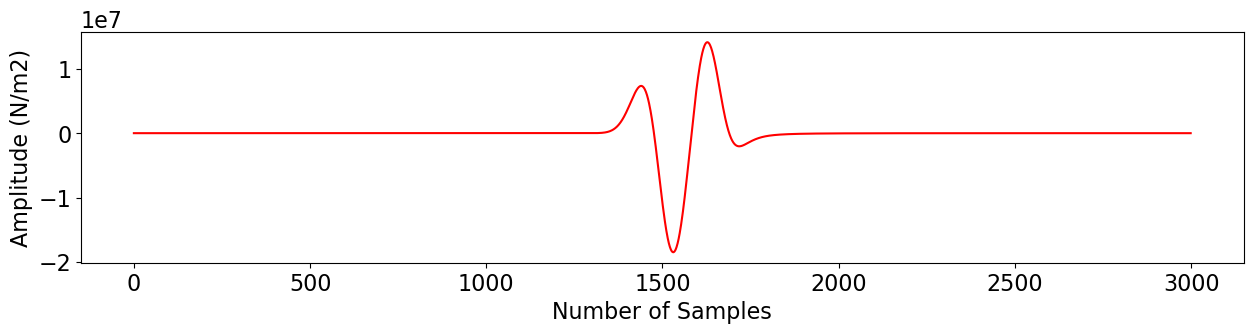

In [9]:
image_name = "seismic_signal_4th.png"

plotting_seismic_signal(seismic_signal, image_name)